# Robot dynamics and simulation
This notebook focuses on the simulation of polyarticulated systems. Based on the collision detection methods available in Pinocchio Coal, we propose to build a complete simulation engine for rigid unilateral contacts, considering only frictionless contact (normal forces and constraints) for simplicity. 

In [1]:
import gepetuto.magic

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide
    the solutions to some questions. Change it for %load if you want to see (and
    execute) the solution.


## Set up

As in the previous exercice, you can count on several scenes of various complexity to test your algorithms:
- a simple scene with 3 convex objects (buildSceneThreeBodies)
- a variation of this first scene with more objects and walls (buildScenePillsBox)
- a stack of cubes of various size (buildSceneCubes)
- a robot hand

In [2]:
from tp5.scenes import buildSceneThreeBodies, buildScenePillsBox, buildSceneCubes, buildSceneRobotHand

The other imports are classical, we will use the robot hand to have a controllable model.

In [3]:
import hppfcl
import pinocchio as pin
import numpy as np
import time
from schaeffler2025.meshcat_viewer_wrapper import MeshcatVisualizer
import matplotlib.pylab as plt

# Build a scene
model,geom_model = buildSceneRobotHand()
q0 = model.referenceConfigurations['default']
data = model.createData()
geom_data = geom_model.createData()

# Start meshcat
viz = MeshcatVisualizer(model=model, collision_model=geom_model,
                        visual_model=geom_model)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [4]:
q=pin.randomConfiguration(model)
viz.display(q)

In [5]:
viz.viewer.jupyter_cell()

## Contact-less dynamic simulation

We now have all the contact information, let's look at the system dynamics. 
We will write first a contact-less simulator, just integrating free fall.
Better use an actuated model for that.

### Evaluating the core elements of the dynamics

In a first time, let's play with the dynamics without constraints.
Choosing an arbitrary joint torque $\tau_q$, inocchio can compute the robot acceleration and integrate it.
The dynamic equation of the robot is $M a_q + b = \tau_q$, with $M$ the mass, $a_q$ the joint acceleration and $b$ the drift.
The mass matrix can be computed using *CRB* algorithm (function of q). The drift is computed using *NLE* (nonlinear effects) algorithm (function of $q$, $v_q$). 


In [6]:
# %load tp4/generated/example_control_init
q = q0.copy()
vq = np.zeros(model.nv)


In [7]:
# %load tp4/generated/example_control_mass
M = pin.crba(model, data, q)
b = pin.nle(model, data, q, vq)

These terms correspond to the inverse dynamics. They can be numerically inverted to compute the direct dynamics.

For example, the acceleration resulting from a torque $\tau_q$ would be $M^{-1} (\tau_q-b)$, or equivalently computed with the ABA algorithm of Pinocchio.

In [8]:
# %load tp5/generated/example_control_dyninv
tauq = np.random.rand(model.nv) * 2 - 1
aq = np.linalg.inv(M) @ (tauq - b)


In [9]:
pin.computeGeneralizedGravity(model,data,q)-b

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
pin.aba(model,data,q,vq,tauq)-aq

array([ 5.55111512e-17,  0.00000000e+00, -8.88178420e-16, -2.77555756e-16,
       -1.33226763e-15, -1.33226763e-15,  1.11022302e-15,  0.00000000e+00,
        4.44089210e-16, -6.66133815e-16,  0.00000000e+00, -4.44089210e-16,
        0.00000000e+00,  1.77635684e-15])

In [11]:
np.diag(M)

array([15.22467586,  5.78194615,  0.59217354,  0.34027   ,  0.09      ,
        0.59217354,  0.34027   ,  0.09      ,  0.59217354,  0.34027   ,
        0.09      ,  0.4105416 ,  0.1601584 ,  0.16      ])

### Integrating the acceleration

Once aq as been computed, it is straight forward to integrate it to velocity using $v_q += a_q \Delta t$. 
Integration to joint position is more complex in general, as we saw for the mobile robot. Here, $n_q = n_v$ and everything is Euclinea, so a simple += integration would work, but since it is implemented in pinocchio, let's keep the good habits:

In [12]:
# %load tp4/generated/example_control_hyper
# Hyperparameters for the simu
DT = 1e-3  # simulation timestep
DT_VISU = 1/50
DURATION = 3. # duration of simulation
T = int(DURATION/DT) # number of time steps


In [13]:
# %load tp4/generated/example_control_integrate
vq += aq * DT
q = pin.integrate(model, q, vq * DT)


Now, you should be able to implement a first simulation (not a rendering any more) of the robot behavior when no torque is applied (tauq = 0).



In [14]:
tauq = np.zeros(model.nv)

Fill the template below to get a free-falling dynamics.

In [15]:
for i in range(T):
    t = i * DT

    # Compute the model.
    # TODO FIX ME

    # Simulated the resulting acceleration (forward dynamics
    # TODO FIX ME
    
    # Integrate the acceleration.
    # TODO FIX ME
    
    # Display once in a while...
    if DT_VISU is not None and abs((t) % DT_VISU)<=0.9*DT:
        viz.display(q)
        time.sleep(DT_VISU)

Now modify the simulator to encompass joint friction, i.e. the torque is opposite to the velocity with a friction coefficient $K_f$ (take $K_f=0.1$ as a start).

### Proportional-derivative and computed torque

Now choose a reference joint position (possibly time varying, like in the hand example).
The joint torques can then be computed to track the desired position, with $\tau_q = -K_p (q-q^{des}) - K_v v_q$. Both gains $K_p$ and $K_v$ should be properly chosen. Optimal tracking is obtained with $K_v = 2 \sqrt{K_p}$. 
In general, a desired velocity is also tracked to avoid tracking errors.



First choose the PD gains:

In [17]:
# %load tp5/generated/example_control_hyper_control
# Hyperparameters for the control
Kp = 50.0  # proportional gain (P of PD)
Kv = 2 * np.sqrt(Kp)  # derivative gain (D of PD)


Then choose a reference trajectory (using the simple class traj_ref introduced for that) which oscillates around a given configuration.

In [18]:
# %load tp5/generated/example_control_trajref
from tp5.traj_ref import TrajRef  # noqa E402

qdes = TrajRef(
    q0,
    omega=np.array([0, 0.1, 1, 1.5, 2.5, -1, -1.5, -2.5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
    amplitude=1.5,
)


Finally, implement the control loop using the following template.

In [25]:
hq = []  ### For storing the logs of measured trajectory q
hqdes = []  ### For storing the logs of desired trajectory qdes
for i in range(T):
    t = i * DT

    # Compute the model.
    M = pin.crba(model, data, q)
    b = pin.nle(model, data, q, vq)

    # Compute the PD control.
    tauq = -Kp * (q - qdes(t)) - Kv * (vq - qdes.velocity(t)) + qdes.acceleration(t)

    # Simulated the resulting acceleration (forward dynamics
    aq = np.linalg.inv(M) @ (tauq - b)

    # Integrate the acceleration.
    vq += aq * DT
    q = pin.integrate(model, q, vq * DT)

    # Display once in a while...
    if DT_VISU is not None and abs((t) % DT_VISU) <= 0.9 * DT:
        viz.display(q)
        time.sleep(DT_VISU)

    # Log the history.
    hq.append(q.copy())
    hqdes.append(qdes.copy())

    # Display once in a while...
    if DT_VISU is not None and abs((t) % DT_VISU)<=0.9*DT:
        viz.display(q)
        time.sleep(DT_VISU)


In [26]:
viz.viewer.jupyter_cell()

Here, there is a strong coupling between joints, due to the mass matrix that is not compensated in the simple PD law. In theory, the computed torques is to compute the joint torque by inverse dynamics from a reference joint acceleration. This boils down to canceling the simulation equation by choosing the proper terms in the control law. It is now very interesting to implement in case of perfect dynamics knowledge. It might be more interesting to study in case the simulation is done with the perfect M, while the control is computed with approximate M (for example, using only the diagonal terms of the mass matrix). Let's rather simulate contact.


It is intersting to plot the results. In the solution of the previous example, the effective and desired position q and qdes have been stored in a log list. We can display them with matplotlib.

Text(0.5, 0, 'Iterations')

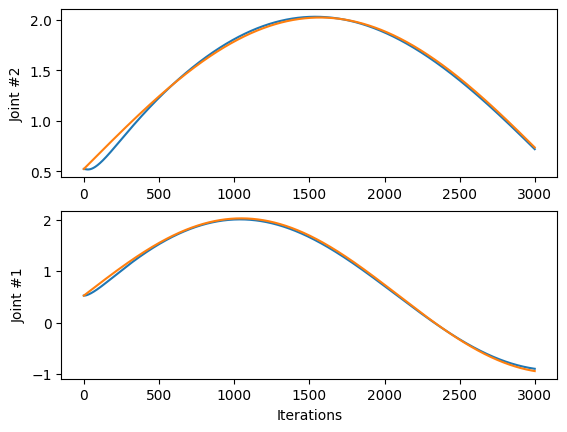

In [20]:
plt.subplot(211)
plt.plot([q[2] for q in hq])
plt.plot([q[2] for q in hqdes])
plt.ylabel('Joint #2')
plt.subplot(212)
plt.plot([q[3] for q in hq])
plt.plot([q[3] for q in hqdes]);
plt.ylabel('Joint #1')
plt.xlabel('Iterations')

Such a basic controller is often called a PD controller, sometimes implementing also a feedforward term. Such a controller gives an active impendance to the robot, making it behave like a damped spring.

## Friction-less simulation

We will now combine the two aspects of the model: the collisions between geometries, and the dynamics of inertias. 

### Choose a model 
Let's come back to a simple model first: a cube on a floor.

In [27]:
from tp5.display_collision_patches import preallocateVisualObjects,updateVisualObjects

In [28]:
# %load tp5/generated/example_simu_frictionless_init
# ### SCENE
# Create scene with multiple objects
model,geom_model = buildSceneCubes(3)

# Create the corresponding data to the models
data = model.createData()
geom_data = geom_model.createData()

for req in geom_data.collisionRequests:
    req.security_margin = 1e-3
    req.num_max_contacts = 20
    req.enable_contact = True

# ### VIZUALIZATION
visual_model = geom_model.copy()
preallocateVisualObjects(visual_model,10)
viz = MeshcatVisualizer(model=model, collision_model=geom_model,
                        visual_model=visual_model)
updateVisualObjects(model,data,[],[],visual_model,viz)

# ### INIT MODEL STATE
q0 = model.referenceConfigurations['default']

viz.display(q0)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [29]:
viz.viewer.jupyter_cell()

### Contact Jacobian

The pin.RigidConstraintModel makes it possible to directly compute the corresponding jacobian. When considering 3D contact models, the jacobian maps the configuration velocity to the relative velocity of the two contact points in the local frame attached to the first witness.
Let's build a basic contact model to show the API:

In [30]:
contact_model = pin.RigidConstraintModel(pin.ContactType.CONTACT_3D,model,1,pin.SE3.Random(), 0, pin.SE3.Identity(), pin.LOCAL)
contact_data = contact_model.createData()

In [31]:
pin.computeJointJacobians(model,data,q0)
np.set_printoptions(precision=3, linewidth=350, suppress=True,threshold=1e6)
pin.getConstraintsJacobian(model,data,[contact_model],[contact_data])

array([[-0.615, -0.056,  0.786, -0.005, -0.197, -0.018,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.64 , -0.618,  0.457, -0.488, -0.941, -0.588,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.46 ,  0.784,  0.416,  0.671, -0.755,  0.681,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

The constraint Jacobian express the constraint in term of velocity of body 1 wrt to body 2. It is more intuitive to think to the opposite: so you have to take the negative Jacobian (ie velocity of body 2 wrt body 1, whose normal component should be positive). Here, we said we will only consider the normal component of the contact, so select the last row (and if there is more than one contact point, every next rows over 3).

In [32]:
Jc = -pin.getConstraintsJacobian(model,data,[contact_model],[contact_data])[2::3]

### Simulation without friction: primal formulation

In [33]:
from tp5.create_rigid_contact_models_for_hppfcl import createContactModelsFromCollisions

You are now in position to write your first complete (friction-less) collision simulator.
The state of the system is the configuration $q$ and velocity $v_q$. The joint torques have to be decided (by a controller) as a function of the state. Here we take them constant null as the cube is unactuated.

In [34]:
q = q0.copy()
v = np.zeros(model.nv)
tau = np.zeros(model.nv)

At each new simulation cycle, you need to choose the next velocity. 
If there is no contact, then the velocity is simply obtained after one step of free fall:

In [35]:
vf = v + DT * pin.aba(model, data, q, v, tau)

You will need a solver to compute the simulation step. With only normal constraints, a QP solver is enough. You can use any of the many available, for example ProxQP. You can get a super quick overview of this solver in the [notebook about it](appendix-proxqp.ipynb).

In [36]:
import proxsuite
QP = proxsuite.proxqp.dense.QP

If there is some collisions, then the next velocity will be as close as possible to the free fall ("as close as possible" in the sense of the metrics imposed by the inertia matrix), while respecting the constraints of positive normal velocities. Mathematically, this writes:

$$\min_{v_+} f(v_+) = \frac{1}{2} \| v_+ - v_f \|_M^2 $$
such that
$$J_c v_+ \ge 0$$

where $f(v_+) = \frac{1}{2} \| v_+ - v_f \|_M^2 = = \frac{1}{2} (v_+-v_f)^T M (v_+-v_f) = \frac{1}{2} v_+^T M v_+ - (M v_f)^T v_+$

This defines a well-shaped LCPQ that can be solved by any off-the-shelf QP solver, [for example ProxQP, as explained in this companion notebook](appendix-proxqp.ipynb) .

Now write the simulation loop. At each simulation cycle:
1. Check the collisions, create the contact model and the corresponding contact data.
2. Evaluate the free-fall next velocity $v_f$ with ABA
3. If no collision, then the next velocity is v_f, continue.
4. If collisions, then evaluate the inertia matrix $M$ with pin.crba, and the Jacobian $J_c$ with pin.getConstraintJacobian; form the primal QP, solve it. The result is the next velocity, the Lagrange multipliers are the contact forces.
5. Optionally, print, display, log.

Here is a canvas:

In [ ]:
# %load tp5/generated/example_simu_frictionless_loop
# ### MAIN LOOP
# ### MAIN LOOP
# ### MAIN LOOP
for t in range(T):

    # Compute free dynamics
    tau = np.zeros(model.nv)
    pin.computeCollisions(model, data, geom_model, geom_data, q)
    vf = v + DT * pin.aba(model, data, q, v, tau)

    # Create contact models from collision
    contact_models = createContactModelsFromCollisions(model,data,geom_model,geom_data)
    contact_datas = [ cm.createData() for cm in contact_models ]
    
    nc = len(contact_models)
    if nc==0:
        # No collision, just integrate the free dynamics
        v = vf
    else:
        # With at least one collision ...
        # Compute mass matrix.
        # (pin.crba should be enough in P3X, but CAT to be sure in P2X);
        pin.computeAllTerms(model, data, q, v)
        # The contact solver express the constraint in term of velocity of
        # body 1 wrt to body 2. It is more intuitive to think to the opposite
        # so take the negative jacobian (ie velocity of body 2 wrt body 1, whose
        # normal component should be positive).
        # Select only normal components of contact
        # (frictionless slide on the tangent components, uncontrained)
        J = -pin.getConstraintsJacobian(model, data, contact_models, contact_datas)[2::3,:]
        assert(J.shape == (nc,model.nv))

        M = data.M

        # ## TODO: formulate the LCQP to compute vnext
        v = np.zeros(model.nv)
    
    # Finally, integrate the valocity
    q = pin.integrate(model , q, v*DT)

    # Visualize once in a while
    if DT_VISU is not None and abs((t*DT) % DT_VISU)<=0.9*DT:
        updateVisualObjects(model,data,contact_models,contact_datas,visual_model,viz)
        viz.display(q)
        time.sleep(DT_VISU)

Should you need it, here is the primal formulation:

In [39]:
%do_not_load_snippet tp5/generated/example_simu_frictionless_primal

The Dual formulation requires another matrix: the Delassus operator, defined as:
$$\Lambda_c = J_c M^{-1} J_c^T$$
Physically, this is the inverse of the apparent (or operational, or contact) inertia, i.e. the mass that an operator would feel if it touches the system in this configuration at the contact points.
The pin.RigidConstraintModel makes it possible to evaluate $\Lambda_c$ more efficiently, but for now that's enough for us.

In [33]:
Minv = pin.computeMinverse(model,data,q)
delasus = J@Minv@J.T

### Simulation without friction: dual formulation

The dual of the contact LCQP that we wrote is:
$$\min_\lambda g(\lambda) = \frac{1}{2} \lambda^T \Lambda_c \lambda + (J_c v_f)^T \lambda$$
subject to
$$\lambda \ge 0$$

Here, the decision variable is $\lambda$ which can be understood as the contact impulses (i.e. $\lambda = f.DT$, the effect of the forces during the timestep). The joint velocity is not appearing in this problem, as all quantities are in the operation (contact) space. 

Once the contact forces are found, the configuration velocity can be evaluated by calling the pin.aba algorithm, while specifying the contact forces.

In [34]:
forces = np.zeros(Jc.shape[0])
vnext = v + DT * pin.aba(model, data, q, v, tau + J.T @ forces/DT)

Now rewrite the simulation problem with the dual formulation. Here is the canvas:

In [35]:
# %load tp5/generated/example_simu_frictionless_loop
# ### MAIN LOOP
# ### MAIN LOOP
# ### MAIN LOOP
for t in range(T):

    # Compute free dynamics
    tau = np.zeros(model.nv)
    pin.computeCollisions(model, data, geom_model, geom_data, q)
    vf = v + DT * pin.aba(model, data, q, v, tau)

    # Create contact models from collision
    contact_models = createContactModelsFromCollisions(model,data,geom_model,geom_data)
    contact_datas = [ cm.createData() for cm in contact_models ]
    
    nc = len(contact_models)
    if nc==0:
        # No collision, just integrate the free dynamics
        v = vf
    else:
        # With at least one collision ...
        # Compute mass matrix.
        # (pin.crba should be enough in P3X, but CAT to be sure in P2X);
        pin.computeAllTerms(model, data, q, v)
        # The contact solver express the constraint in term of velocity of
        # body 1 wrt to body 2. It is more intuitive to think to the opposite
        # so take the negative jacobian (ie velocity of body 2 wrt body 1, whose
        # normal component should be positive).
        # Select only normal components of contact
        # (frictionless slide on the tangent components, uncontrained)
        J = -pin.getConstraintsJacobian(model, data, contact_models, contact_datas)[2::3,:]
        assert(J.shape == (nc,model.nv))

        Minv = pin.computeMinverse(model,data,q)
        delasus = J@Minv@J.T

        # ## TODO: formulate the dual LCQP to compute lambda
        forces = np.zeros(delasus.shape[0])

        # The next velocity results from the contact forces
        vnext = v + DT * pin.aba(model, data, q, v, tau + J.T @ forces/DT)

    # Finally, integrate the valocity
    q = pin.integrate(model , q, v*DT)

    # Visualize once in a while
    if DT_VISU is not None and abs((t*DT) % DT_VISU)<=0.9*DT:
        updateVisualObjects(model,data,contact_models,contact_datas,visual_model,viz)
        viz.display(q)
        time.sleep(DT_VISU)

Here is the dual formulation, should you need it.

In [36]:
%do_not_load_snippet tp5/generated/example_simu_frictionless_dual

### Comparison: primal / dual

Once you have implemented both primal and dual formulations, you can double check that the results are the same.

In [37]:
# %load tp5/generated/example_simu_frictionless_check
# Check QP2 primal vs QP1 dual
assert np.allclose(qp2.results.x, -qp1.results.z, rtol=1e-3, atol=1e-4)
# Check QP2 constraint vs QP1 constraint
assert np.allclose(
    delasus @ qp2.results.x + J @ vf, J @ qp1.results.x, rtol=1, atol=1e-5
)


NameError: name 'qp2' is not defined